# EoR Signal Separation with CWT Method

---

### Weitian LI

https://github.com/liweitianux/cdae-eor

**Credit**:
[Junhua GU](https://github.com/astrojhgu)

---

## Introduction

The foreground spectra are smooth in frequency domain, while the EoR signal fluctuates rapidly along
the frequency dimension, i.e., its spectrum is full of saw-tooth-like structures.  Therefore their
characteriestic scales are significantly different.  By applying the continuous wavelet transform (CWT),
they should be well separated.

**Reference**:
[Gu et al. 2013, ApJ, 773, 38](http://adsabs.harvard.edu/abs/2013ApJ...773...38G)

---

## 1. Import packages and basic settings

In [1]:
import os
from os import path

import numpy as np
from scipy import signal
from astropy.io import fits

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
mpl.style.use("ggplot")
for k, v in [("font.family",       "Inconsolata"),
             ("font.size",         14.0),
             ("pdf.fonttype",      42),  # Type 42 (a.k.a. TrueType)
             ("figure.figsize",    [8, 6]),
             ("image.cmap",        "jet"),
             ("xtick.labelsize",   "large"),
             ("xtick.major.size",  7.0),
             ("xtick.major.width", 2.0),
             ("xtick.minor.size",  4.0),
             ("xtick.minor.width", 1.5),
             ("ytick.labelsize",   "large"),
             ("ytick.major.size",  7.0),
             ("ytick.major.width", 2.0),
             ("ytick.minor.size",  4.0),
             ("ytick.minor.width", 1.5)]:
    mpl.rcParams[k] = v

In [4]:
import sys

p = path.expanduser('~/git/cdae-eor/cwt/pycwt1d')
if p not in sys.path:
    sys.path.insert(0, p)

import cwt1d

---

## 2. Custom functions

In [5]:
def rms(a, axis=None):
    return np.sqrt(np.mean(a**2, axis=axis))

In [6]:
def a_summary(a):
    print('min:', np.min(a))
    print('max:', np.max(a))
    print('mean:', np.mean(a))
    print('std:', np.std(a))
    print('median:', np.median(a))

In [7]:
# correlation coefficient

def corrcoef(s1, s2):
    # calculate: np.corrcoef(s1, s2)[0, 1]
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    return np.sum((s1-m1) * (s2-m2)) / np.sqrt(np.sum((s1-m1)**2) * np.sum((s2-m2)**2))


def corrcoef_ds(ds1, ds2):
    # shape: [npix, nfreq]
    n = ds1.shape[0]
    cc = np.zeros((n,))
    for i in range(n):
        cc[i] = corrcoef(ds1[i, :], ds2[i, :])
    return cc


def corrcoef_freqpix(fparray1, fparray2):
    # shape: [nfreq, npix]
    __, npix = fparray1.shape
    cc = np.zeros((npix,))
    for i in range(npix):
        cc[i] = corrcoef(fparray1[:, i], fparray2[:, i])
    return cc

---

## 3. Load data

In [8]:
datadir = '../data'
cube_eor = fits.open(path.join(datadir, 'eor.uvcut.sft_b158c80_n360-cube.fits'))[0].data.astype(float)
cube_fg  = fits.open(path.join(datadir, 'fg.uvcut.sft_b158c80_n360-cube.fits' ))[0].data.astype(float)
cube_tot = cube_fg + cube_eor

In [9]:
nfreq, ny, nx = cube_eor.shape
npix = nx * ny
freqs = np.linspace(154, 162, nfreq)
fmid = (freqs[1:] + freqs[:-1]) / 2

nfreq, ny, nx, npix

(101, 360, 360, 129600)

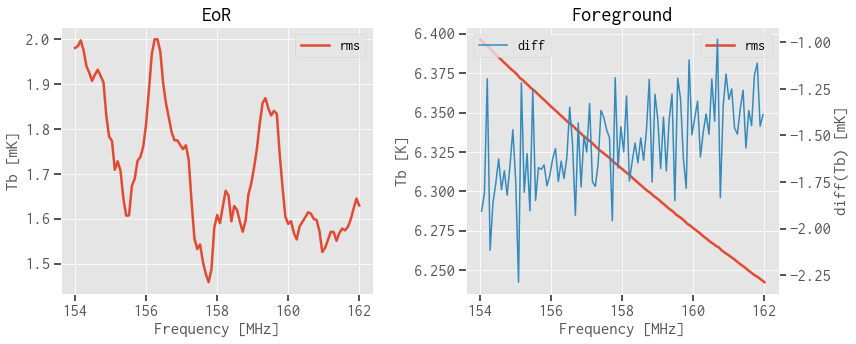

In [10]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

ax = ax0
eor_rms = rms(cube_eor, axis=(1,2)) * 1e3  # mK
ax.plot(freqs, eor_rms, lw=2.5, label='rms')
ax.legend()
ax.set(xlabel='Frequency [MHz]', ylabel='Tb [mK]', title='EoR')

ax = ax1
fg_rms = rms(cube_fg, axis=(1,2))
ax.plot(freqs, fg_rms, lw=2.5, label='rms')
ax.legend()
ax.set(xlabel='Frequency [MHz]', ylabel='Tb [K]', title='Foreground')
ax_ = ax.twinx()
ax_.plot(fmid, np.diff(fg_rms)*1e3, color='C1', label='diff')
ax_.legend()
ax_.set(ylabel='diff(Tb) [mK]')
ax_.grid(False)

fig.tight_layout()
plt.show()

---

## 4. Tune parameters

In [11]:
x_input = np.array(cube_tot.reshape((nfreq, npix)))
x_label = np.array(cube_eor.reshape((nfreq, npix)))

In [12]:
x1 = x_input[:, 0]
y1 = x_label[:, 0]

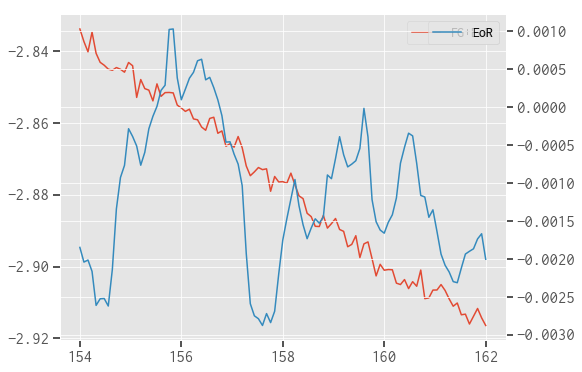

In [13]:
fig, ax = plt.subplots()
ax.plot(freqs, x1, color='C0', label='FG+EoR')
ax.legend()
ax_ = ax.twinx()
ax_.plot(freqs, y1, color='C1', label='EoR')
ax_.legend()
plt.show()

In [60]:
def plot_cwt(mask, coef):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 4))
    ax0.imshow(mask, origin='lower')
    ax0.grid(False)
    ax0.set(title='mask')
    ax1.imshow(np.abs(coef), origin='lower')
    ax1.grid(False)
    ax1.set(title='coefficient')
    fig.tight_layout()
    plt.show()
    return (fig, (ax0, ax1))


def test_cwt(data, coi, s_min, s_max, num_scales=50, nig=10, plot=True):
    xin, xlabel = data
    nfreq = len(xin)
    mwf = cwt1d.morlet(2*np.pi)
    scale = cwt1d.generate_log_scales(s_min, s_max, num_scales)
    mask = cwt1d.cwt_filter.generate_mask(nfreq, scale, coi)
    coef = cwt1d.cwt(x1, scale, mwf)
    xout = cwt1d.icwt(coef*mask, scale, mwf)
    
    if plot:
        plot_cwt(mask, coef)
    cc = corrcoef(xout[nig:-nig], xlabel[nig:-nig])
    print(f'cc: {cc:.4f}')
    
    return {
        'xout': xout,
        'mask': mask,
        'coef': coef,
        'cc': cc,
    }

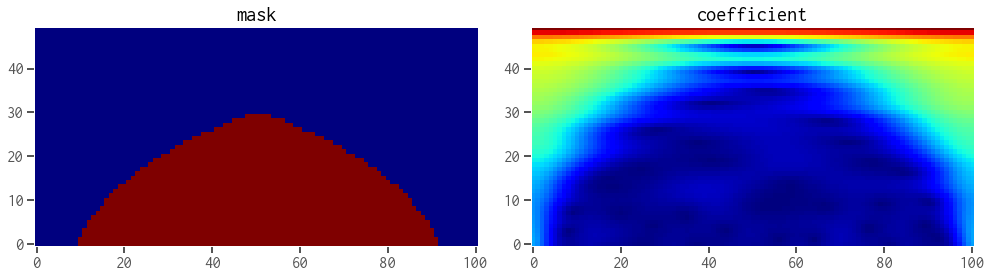

cc: 0.1623


In [48]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=3, s_max=50)

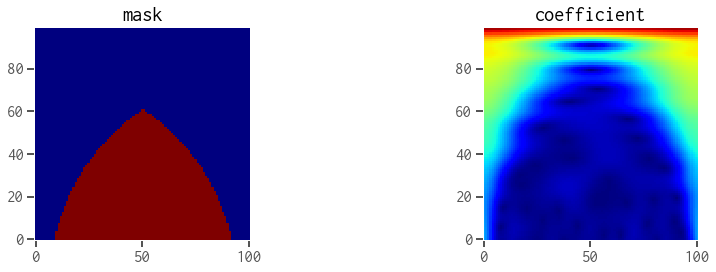

cc: 0.1627


In [49]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=3, s_max=50, num_scales=100)

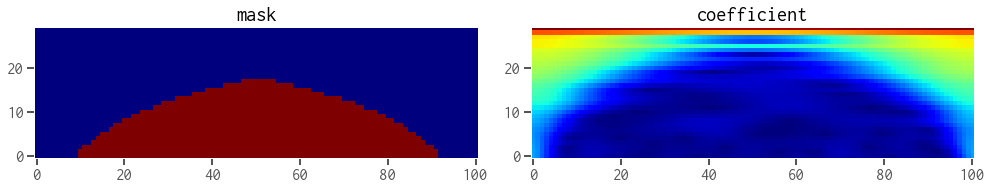

cc: 0.1634


In [51]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=3, s_max=50, num_scales=30)

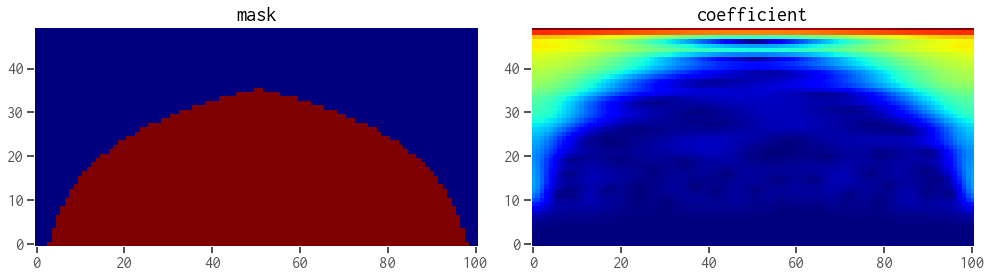

cc: 0.1245


In [50]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=1, s_max=50)

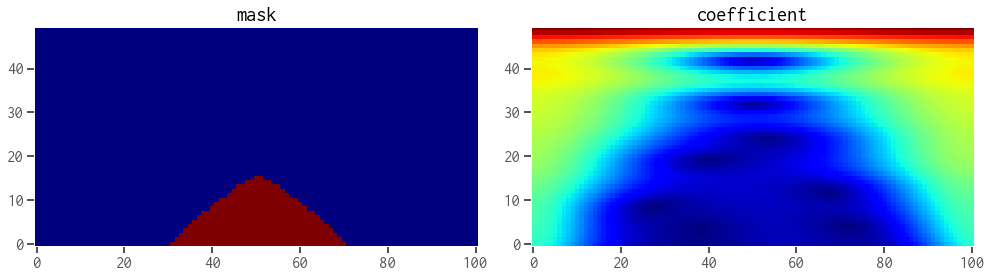

cc: 0.2089


In [52]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=10, s_max=50)

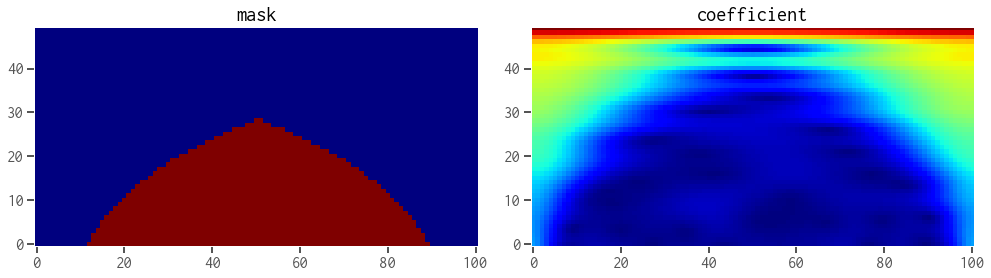

cc: 0.1808


In [54]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=3.8, s_max=50)

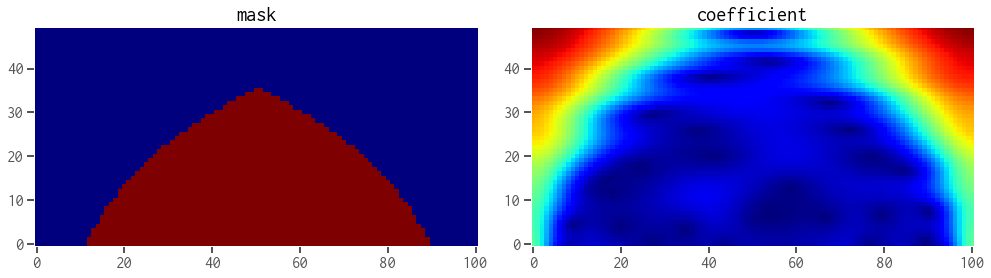

cc: 0.1817


In [55]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=3.8, s_max=30)

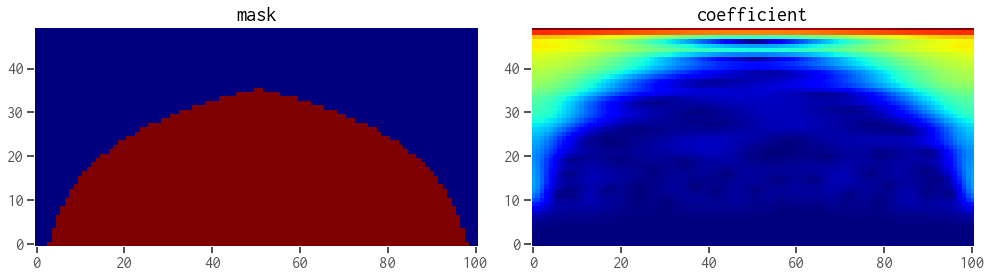

cc: 0.1245


In [56]:
ret = test_cwt(data=(x1, y1), coi=3, s_min=1, s_max=50)

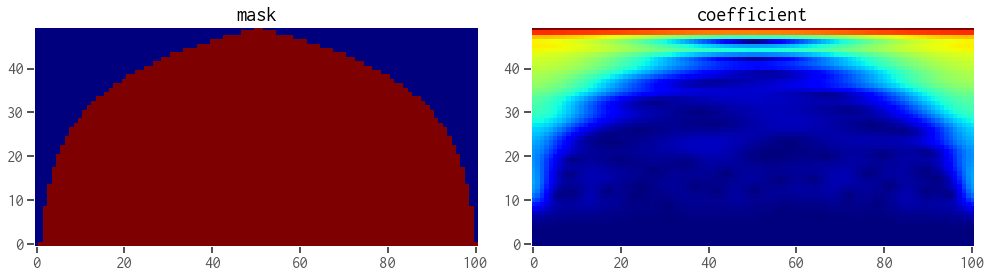

cc: 0.0924


In [58]:
ret = test_cwt(data=(x1, y1), coi=1, s_min=1, s_max=50)

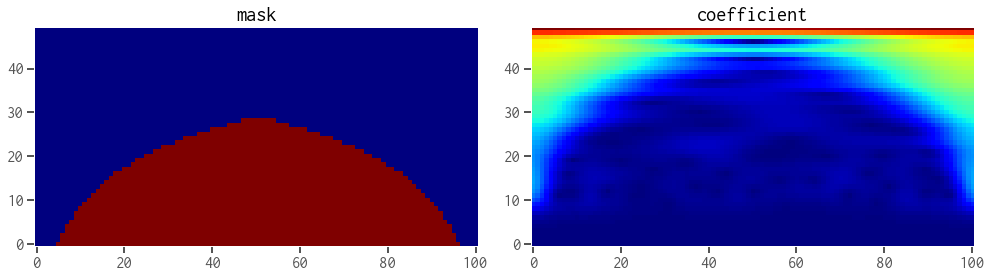

cc: 0.0698


In [59]:
ret = test_cwt(data=(x1, y1), coi=5, s_min=1, s_max=50)

In [63]:
for p in np.arange(1, 5, 0.1):
    print(f'coi={p:.1f} ... ', end='', flush=True)
    ret = test_cwt(data=(x1, y1), coi=p, s_min=1, s_max=50, plot=False)

coi=1.0 ... cc: 0.0924
coi=1.1 ... cc: 0.1043
coi=1.2 ... cc: 0.1281
coi=1.3 ... cc: 0.1542
coi=1.4 ... cc: 0.1769
coi=1.5 ... cc: 0.1937
coi=1.6 ... cc: 0.1967
coi=1.7 ... cc: 0.1916
coi=1.8 ... cc: 0.1865
coi=1.9 ... cc: 0.1752
coi=2.0 ... cc: 0.1709
coi=2.1 ... cc: 0.1657
coi=2.2 ... cc: 0.1628
coi=2.3 ... cc: 0.1595
coi=2.4 ... cc: 0.1553
coi=2.5 ... cc: 0.1518
coi=2.6 ... cc: 0.1457
coi=2.7 ... cc: 0.1412
coi=2.8 ... cc: 0.1350
coi=2.9 ... cc: 0.1301
coi=3.0 ... cc: 0.1245
coi=3.1 ... cc: 0.1204
coi=3.2 ... cc: 0.1159
coi=3.3 ... cc: 0.1130
coi=3.4 ... cc: 0.1083
coi=3.5 ... cc: 0.1050
coi=3.6 ... cc: 0.1013
coi=3.7 ... cc: 0.0997
coi=3.8 ... cc: 0.0967
coi=3.9 ... cc: 0.0934
coi=4.0 ... cc: 0.0915
coi=4.1 ... cc: 0.0893
coi=4.2 ... cc: 0.0859
coi=4.3 ... cc: 0.0838
coi=4.4 ... cc: 0.0816
coi=4.5 ... cc: 0.0786
coi=4.6 ... cc: 0.0769
coi=4.7 ... cc: 0.0751
coi=4.8 ... cc: 0.0729
coi=4.9 ... cc: 0.0702


In [64]:
coi = 1.6
for p in np.arange(1, 10, 0.2):
    print(f's_min={p:.1f} ... ', end='', flush=True)
    ret = test_cwt(data=(x1, y1), coi=coi, s_min=p, s_max=50, plot=False)

s_min=1.0 ... cc: 0.1967
s_min=1.2 ... cc: 0.1965
s_min=1.4 ... cc: 0.1972
s_min=1.6 ... cc: 0.1969
s_min=1.8 ... cc: 0.2003
s_min=2.0 ... cc: 0.2055
s_min=2.2 ... cc: 0.2109
s_min=2.4 ... cc: 0.2170
s_min=2.6 ... cc: 0.2251
s_min=2.8 ... cc: 0.2313
s_min=3.0 ... cc: 0.2409
s_min=3.2 ... cc: 0.2490
s_min=3.4 ... cc: 0.2502
s_min=3.6 ... cc: 0.2575
s_min=3.8 ... cc: 0.2600
s_min=4.0 ... cc: 0.2674
s_min=4.2 ... cc: 0.2715
s_min=4.4 ... cc: 0.2737
s_min=4.6 ... cc: 0.2758
s_min=4.8 ... cc: 0.2765
s_min=5.0 ... cc: 0.2805
s_min=5.2 ... cc: 0.2800
s_min=5.4 ... cc: 0.2816
s_min=5.6 ... cc: 0.2815
s_min=5.8 ... cc: 0.2889
s_min=6.0 ... cc: 0.2901
s_min=6.2 ... cc: 0.2980
s_min=6.4 ... cc: 0.3036
s_min=6.6 ... cc: 0.3070
s_min=6.8 ... cc: 0.3105
s_min=7.0 ... cc: 0.3141
s_min=7.2 ... cc: 0.3129
s_min=7.4 ... cc: 0.3180
s_min=7.6 ... cc: 0.3175
s_min=7.8 ... cc: 0.3193
s_min=8.0 ... cc: 0.3204
s_min=8.2 ... cc: 0.3169
s_min=8.4 ... cc: 0.3169
s_min=8.6 ... cc: 0.3173
s_min=8.8 ... cc: 0.3149


In [68]:
coi = 1.6
s_min = 7.4
for p in np.arange(30, 100, 2.0, dtype=float):
    print(f's_max={p:.1f} ... ', end='', flush=True)
    ret = test_cwt(data=(x1, y1), coi=coi, s_min=s_min, s_max=p, plot=False)

s_max=30.0 ... cc: 0.3190
s_max=32.0 ... cc: 0.3164
s_max=34.0 ... cc: 0.3173
s_max=36.0 ... cc: 0.3177
s_max=38.0 ... cc: 0.3167
s_max=40.0 ... cc: 0.3178
s_max=42.0 ... cc: 0.3167
s_max=44.0 ... cc: 0.3158
s_max=46.0 ... cc: 0.3164
s_max=48.0 ... cc: 0.3151
s_max=50.0 ... cc: 0.3180
s_max=52.0 ... cc: 0.3153
s_max=54.0 ... cc: 0.3158
s_max=56.0 ... cc: 0.3171
s_max=58.0 ... cc: 0.3173
s_max=60.0 ... cc: 0.3179
s_max=62.0 ... cc: 0.3149
s_max=64.0 ... cc: 0.3160
s_max=66.0 ... cc: 0.3183
s_max=68.0 ... cc: 0.3172
s_max=70.0 ... cc: 0.3171
s_max=72.0 ... cc: 0.3142
s_max=74.0 ... cc: 0.3141
s_max=76.0 ... cc: 0.3163
s_max=78.0 ... cc: 0.3179
s_max=80.0 ... cc: 0.3196
s_max=82.0 ... cc: 0.3171
s_max=84.0 ... cc: 0.3165
s_max=86.0 ... cc: 0.3179
s_max=88.0 ... cc: 0.3172
s_max=90.0 ... cc: 0.3144
s_max=92.0 ... cc: 0.3164
s_max=94.0 ... cc: 0.3160
s_max=96.0 ... cc: 0.3169
s_max=98.0 ... cc: 0.3183


In [73]:
coi = 1.6
s_min = 7.4
s_max = 50.0
for p in np.arange(30, 100, 2, dtype=np.int32):
    print(f'num_scales={p} ... ', end='', flush=True)
    ret = test_cwt(data=(x1, y1), coi=coi, s_min=s_min, s_max=s_max, num_scales=p, plot=False)

num_scales=30 ... cc: 0.3177
num_scales=32 ... cc: 0.3114
num_scales=34 ... cc: 0.3201
num_scales=36 ... cc: 0.3143
num_scales=38 ... cc: 0.3194
num_scales=40 ... cc: 0.3172
num_scales=42 ... cc: 0.3169
num_scales=44 ... cc: 0.3188
num_scales=46 ... cc: 0.3189
num_scales=48 ... cc: 0.3166
num_scales=50 ... cc: 0.3180
num_scales=52 ... cc: 0.3189
num_scales=54 ... cc: 0.3190
num_scales=56 ... cc: 0.3177
num_scales=58 ... cc: 0.3172
num_scales=60 ... cc: 0.3179
num_scales=62 ... cc: 0.3177
num_scales=64 ... cc: 0.3165
num_scales=66 ... cc: 0.3160
num_scales=68 ... cc: 0.3158
num_scales=70 ... cc: 0.3166
num_scales=72 ... cc: 0.3171
num_scales=74 ... cc: 0.3167
num_scales=76 ... cc: 0.3155
num_scales=78 ... cc: 0.3159
num_scales=80 ... cc: 0.3176
num_scales=82 ... cc: 0.3151
num_scales=84 ... cc: 0.3184
num_scales=86 ... cc: 0.3164
num_scales=88 ... cc: 0.3166
num_scales=90 ... cc: 0.3159
num_scales=92 ... cc: 0.3172
num_scales=94 ... cc: 0.3150
num_scales=96 ... cc: 0.3158
num_scales=98 

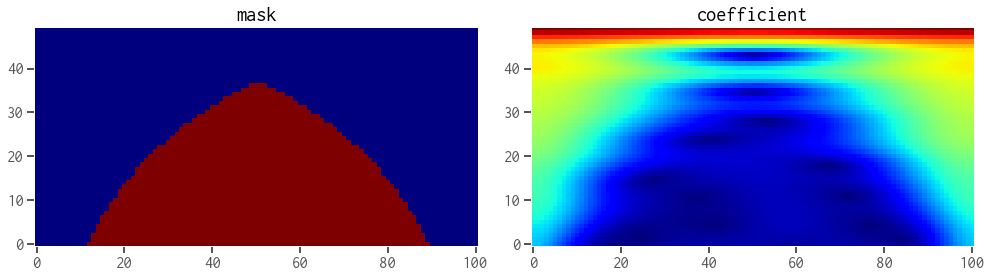

cc: 0.3180


In [76]:
coi = 1.6
s_min = 7.4
s_max = 50.0
num_scales = 50

ret = test_cwt(data=(x1, y1), coi=coi, s_min=s_min, s_max=s_max, num_scales=num_scales)

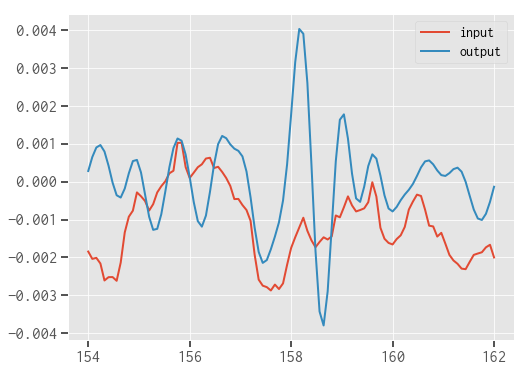

In [79]:
fig, ax = plt.subplots()
ax.plot(freqs, y1, lw=2, label='input')
ax.plot(freqs, ret['xout'], lw=2, label='output')
ax.legend()
plt.show()

---

## 5. Results

In [97]:
nig = 10
cwt_args = {
    'coi': coi,
    's_min': s_min,
    's_max': s_max,
    'num_scales': num_scales,
    'nig': nig,
}

In [89]:
def fgrm_cwt(x_input, **kwargs):
    if x_input.ndim == 1:
        nfreq = len(x_input)
        npix = 1
    else:
        nfreq, npix = x_input.shape
    mwf = cwt1d.morlet(2*np.pi)
    scale = cwt1d.generate_log_scales(kwargs['s_min'], kwargs['s_max'], kwargs['num_scales'])
    mask = cwt1d.cwt_filter.generate_mask(nfreq, scale, kwargs['coi'])
    
    if npix == 1:
        coef = cwt1d.cwt(x_input, scale, mwf)
        return cwt1d.icwt(coef*mask, scale, mwf)
    
    out = np.zeros((nfreq, npix))
    percent = npix // 100
    for i in range(npix):
        if npix > 1e3 and i % percent == 0:
            print('%d..' % (i//percent), end='', flush=True)
        coef = cwt1d.cwt(x_input[:, i], scale, mwf)
        out[:, i] = cwt1d.icwt(coef*mask, scale, mwf)
    if npix > 1e3:
        print('', flush=True)
    
    return out

#### 5% dataset

In [85]:
idx = np.arange(npix)
np.random.seed(42)
np.random.shuffle(idx)

n = int(npix * 0.05)  # 5%
x_idx = idx[:n]
x_tot = x_input[:, x_idx]
x_eor = x_label[:, x_idx]
x_eor.shape

(101, 6480)

In [88]:
%%time
x_out = fgrm_cwt(x_tot, **cwt_args)

CPU times: user 21.8 s, sys: 10.9 ms, total: 21.8 s
Wall time: 21.8 s


In [100]:
cc = corrcoef_freqpix(x_out[nig:-nig, :], x_eor[nig:-nig, :])
print('rho: %.4f +/- %.4f' % (cc.mean(), cc.std()))
np.mean(np.abs(cc)), np.std(cc), rms(cc), np.percentile(cc, q=(25, 50, 75))

rho: 0.1990 +/- 0.1602


(0.21602965187407622,
 0.16016931924592756,
 0.2554609133810389,
 array([0.10021971, 0.1868698 , 0.30511591]))

#### 20% dataset

In [101]:
idx = np.arange(npix)
np.random.seed(42)
np.random.shuffle(idx)

n = int(npix * 0.2)  # 20%
x_idx = idx[:n]
x_tot = x_input[:, x_idx]
x_eor = x_label[:, x_idx]
x_eor.shape

(101, 25920)

In [102]:
%%time
x_out = fgrm_cwt(x_tot, **cwt_args)

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..
CPU times: user 1min 28s, sys: 499 ms, total: 1min 28s
Wall time: 1min 26s


In [103]:
cc = corrcoef_freqpix(x_out[nig:-nig, :], x_eor[nig:-nig, :])
print('rho: %.4f +/- %.4f' % (cc.mean(), cc.std()))
np.mean(np.abs(cc)), np.std(cc), rms(cc), np.percentile(cc, q=(25, 50, 75))

rho: 0.1995 +/- 0.1603


(0.21674882757878491,
 0.16026546322735066,
 0.25587498950279886,
 array([0.10052021, 0.18960094, 0.30671743]))

#### full dataset

In [104]:
%%time
x_out = fgrm_cwt(x_input, **cwt_args)

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..
CPU times: user 7min 14s, sys: 841 ms, total: 7min 15s
Wall time: 7min 12s


In [105]:
cc = corrcoef_freqpix(x_out[nig:-nig, :], x_label[nig:-nig, :])
print('rho: %.4f +/- %.4f' % (cc.mean(), cc.std()))
np.mean(np.abs(cc)), np.std(cc), rms(cc), np.percentile(cc, q=(25, 50, 75))

rho: 0.1982 +/- 0.1600


(0.21556690467549142,
 0.1600460813816895,
 0.2547367812508584,
 array([0.09879688, 0.18832434, 0.30504483]))